<a href="https://colab.research.google.com/github/5starkarma/vehicle_registration_plate_object_detection/blob/master/vehicle_registration_plate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font style="color:blue">Project 3: Object Detection</font>


#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Plot Ground Truth Bounding Boxes</h3></td> <td><h3>20</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Training</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Inference</h3></td> <td><h3>15</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>COCO Detection Evaluation</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Run Inference on a Video</h3></td> <td><h3>15</h3></td> </tr>
    </table>
</div>


In [266]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# <font style="color:purple">Download the Dataset</font> 

**[Download the Vehicle registration plate](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1)**


Download the traffic-sign dataset from [here](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1) and unzip it. 

We will have the following directory structure:

```
Dataset
├── train
│   └── Vehicle registration plate
│       └── Label
└── validation
    └── Vehicle registration plate
        └── Label
```

Unzipping the file will give you a directory `Dataset`. This directory has two folder `train` and `validation`. Each train and validation folder has `Vehicle registration plate`  folder with `.jpg` images and a folder `Labels`.  `Labels` folder has bounding box data for the images.


For example,
For image: `Dataset/train/Vehicle registration plate/bf4689922cdfd532.jpg`
Label file is  `Dataset/train/Vehicle registration plate/Label/bf4689922cdfd532.txt`

There are one or more lines in each `.txt` file. Each line represents one bounding box.
For example,
```
Vehicle registration plate 385.28 445.15 618.24 514.225
Vehicle registration plate 839.68 266.066462 874.24 289.091462
```

We have a single class detection (`Vehicle registration plate detection`) problem. So bounding box details start from the fourth column in each row.

Representation is in `xmin`, `ymin`, `xmax`, and `ymax` format.

**It has `5308` training and `386` validation dataset.**

Data is downloaded from [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html)

#  <font style="color:green">1. Plot Ground Truth Bounding Boxes [20 Points]</font> 

**You have to show three images from validation data with the bounding boxes.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g3.png'>



In [267]:
import glob
import os
import random
from collections import defaultdict

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# model_zoo has a lots of pre-trained model
from detectron2 import model_zoo

# DefaultTrainer is a class for training object detector
from detectron2.engine import DefaultTrainer
# DefaultPredictor is class for inference
from detectron2.engine import DefaultPredictor

# detectron2 has its configuration format
from detectron2.config import get_cfg
# detectron2 has implemented Visualizer of object detection
from detectron2.utils.visualizer import Visualizer

# from DatasetCatalog, detectron2 gets dataset and from MetadatCatalog it gets metadata of the dataset
from detectron2.data import DatasetCatalog, MetadataCatalog

# BoxMode support bounding boxes in different format
from detectron2.structures import BoxMode

# COCOEvaluator based on COCO evaluation metric, inference_on_dataset is used for evaluation for a given metric
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# build_detection_test_loader, used to create test loader for evaluation
from detectron2.data import build_detection_test_loader

import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['image.cmap'] = 'gray'

# My implementation of visualizing the data

I created this implementation before seeing the format requirements given by Detectron2

In [268]:
data_root = '/content/drive/My Drive/Datasets/vehicle_registration_plate_dataset/Dataset'

train_data_dir = '/train/Vehicle registration plate'
train_label_dir = '/train/Vehicle registration plate/Label'

val_data_dir = '/validation/Vehicle registration plate'
val_label_dir = '/validation/Vehicle registration plate/Label'

['Vehicle registration plate 213.47328 251.42391100000003 338.244608 349.86674999999997\n']
['Vehicle registration plate 413.641728 267.666432 682.627072 400.24473600000005\n']
['Vehicle registration plate 100.448256 319.109376 134.300672 329.14176\n', 'Vehicle registration plate 158.186496 584.3312639999999 299.175936 658.395648\n', 'Vehicle registration plate 680.955904 256.406784 697.254912 263.93088\n', 'Vehicle registration plate 806.406144 323.82336 854.54336 339.08966399999997\n']


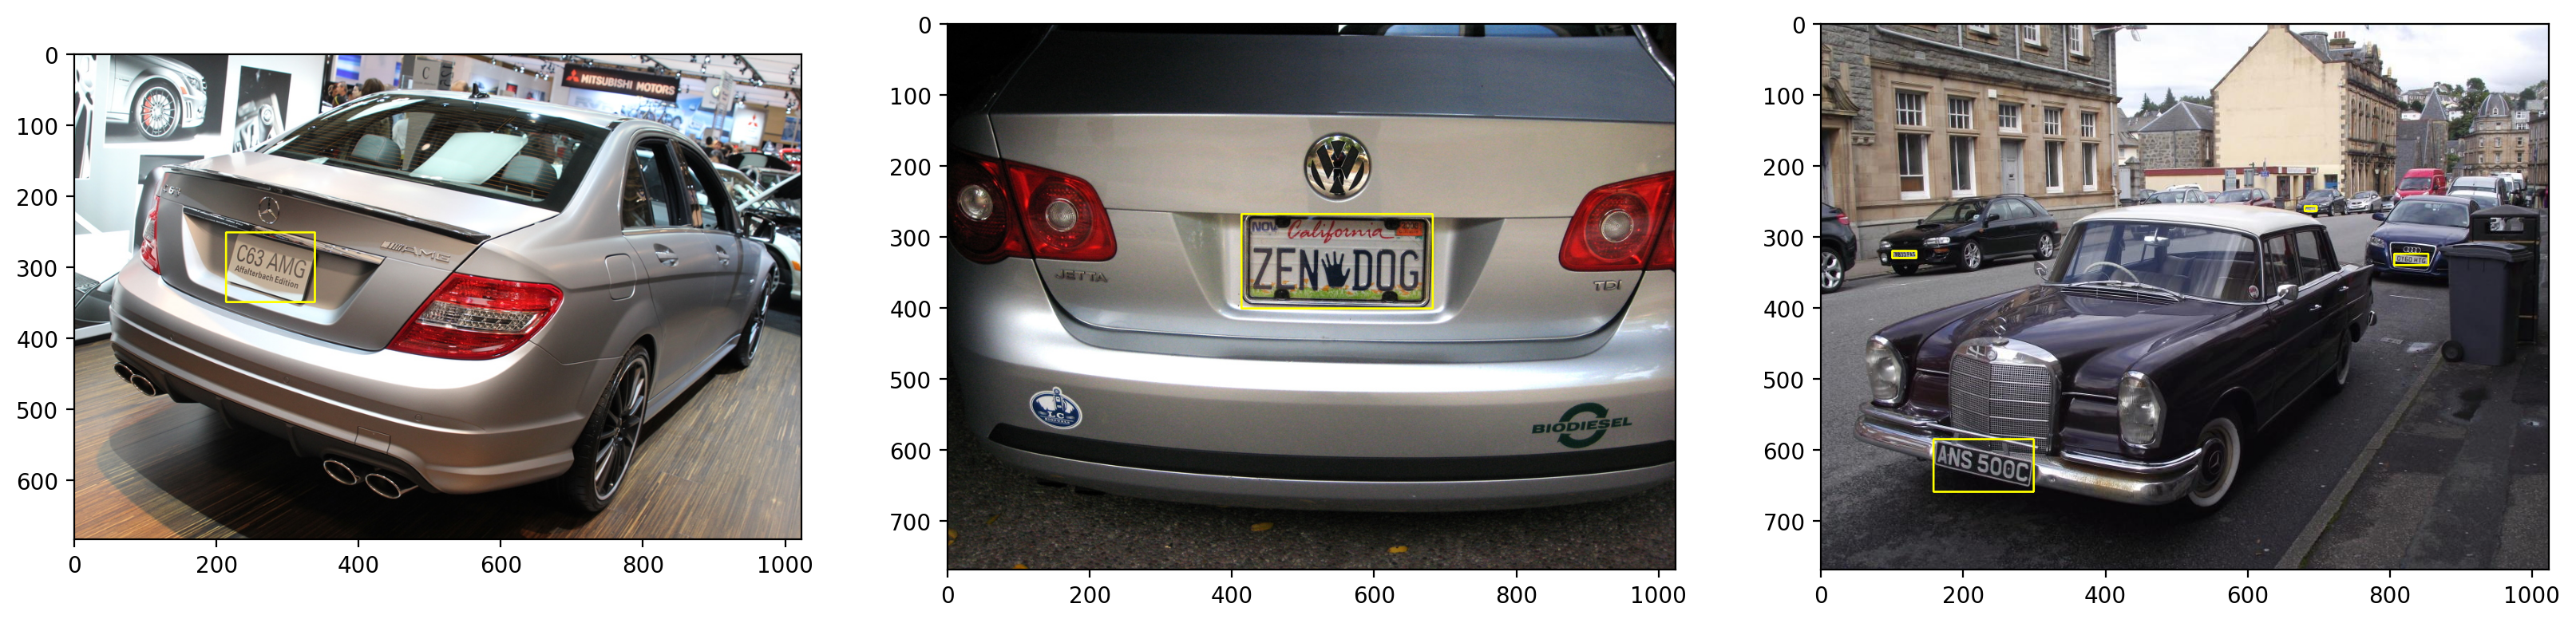

In [314]:
file_dict = defaultdict(list)

for filepath in glob.glob(data_root + val_label_dir + '/*.txt')[:3]:
  with open(filepath) as f:
    filepath = os.path.split(filepath)[1].replace('txt','jpg')
    lines = f.readlines()
    print(lines)

    if filepath not in file_dict:
      file_dict[filepath] = lines

    for key, value in file_dict.items():
      file_dict[key] = [val.lstrip('Vehicle registration plate').strip('\n') for val in value]

fig = plt.figure(figsize=(20,20), dpi=200)

columns = 3
rows = 1
image_num = 1

for key, value in file_dict.items():
  image = cv2.imread(os.path.join(val_dir, key))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  for list_item in value:
    list_vals = list_item.split()

    x1 = int(float(list_vals[0]))
    y1 = int(float(list_vals[1]))
    x2 = int(float(list_vals[2]))
    y2 = int(float(list_vals[3]))

    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)
  
  fig.add_subplot(rows, columns, image_num)
  plt.imshow(image)

  image_num += 1

# Install Pycocotools

In [270]:
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# Install Pre-built Detectron2

In [271]:
# for CUDA 10.1:1
# You can replace cu101 with cu{100,92} or cpu.
# !pip install --ignore-installed PyYAML # needed YAML upgrade
# !python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

# Dataset in Detectron2 Format

Detectron2 needs data in a list of dictionary (list[dict]) format.

The dictionary (dict) should have the following format, :

```
{
    'file_name': str,              # path of the image
    'image_id': int or str,        # a unique id that identifies the image.
    'height': int,                 # height of the image,
    'width': int,                  # width of the image
    'annotations': [
            {
                'bbox': [xmin, ymin, xmax, ymax],   # bounding box in XYXY_ABS format
                'bbox_mode': BoxMode.XYXY_ABS,      # it supports bounding box in different format
                'category_id': int,                 # class id 
                'iscrowd': 0 or 1                   # if it is a crowd of the objects. 
                                                    # In our case it will be 0
            }
      ]
}
```

A function that loads the dataset into detectron2's standard format

In [339]:
def get_vehicle_registration_plate_dicts(data_root, txt_file_dir):

    dataset_dicts = []
    filenames = [] # image paths

    # adding all the filenames to a list from the txt file
    for filepath in glob.glob(data_root + txt_file_dir + '/Label' + '/*.txt'):
        with open(filepath, 'r') as f:
            filepath = os.path.split(filepath)[1].replace('txt','jpg')
            # lines = f.readlines()
            filenames.append(filepath)

    # print(filenames)

    # opening that list and then the image
    for idx, filename in enumerate(filenames):
        record = {}
        
        image_path = data_root + txt_file_dir + '/' + filename
        
        height, width = cv2.imread(image_path).shape[:2]
        
        record['file_name'] = image_path
        record['image_id'] = idx
        record['height'] = height
        record['width'] = width

        # print(f'Record: {record}')
        
        image_filename = os.path.basename(filename)
        image_name = os.path.splitext(image_filename)[0]

        annotation_path = data_root + txt_file_dir + '/Label' + f'/{image_name}.txt'
        # print(f'Annotation path: {annotation_path}')
        annotation_rows = []

        with open(annotation_path, "r") as f:
            filepath = os.path.split(filepath)[1]
            lines = f.readlines()
            for line in lines:
                lines = line.lstrip('Vehicle registration plate').strip('\n')
            annotation_rows.append(lines)
        # print(f'Annotation rows: {annotation_rows}')

        objs = []
        
        for row in annotation_rows:
            list_vals = row.split()

            x1 = int(float(list_vals[0]))
            y1 = int(float(list_vals[1]))
            x2 = int(float(list_vals[2]))
            y2 = int(float(list_vals[3]))

            obj= {
                'bbox': [x1, y1, x2, y2],
                'bbox_mode': BoxMode.XYXY_ABS,
                # alternatively, we can use bbox_mode = BoxMode.XYWH_ABS
                # 'bbox': [xmin, ymin, bwidth, bheight],
                # 'bbox_mode': BoxMode.XYWH_ABS,
                'category_id': 0,
                'iscrowd': 0
            }
        
            objs.append(obj)
        record['annotations'] = objs
        dataset_dicts.append(record)

    return dataset_dicts

In [340]:
# lets visualize the data

test_data_dict = get_vehicle_registration_plate_dicts(data_root, val_data_dir)

print(test_data_dict)
for d in random.sample(test_data_dict, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], 
                            metadata=test_metadata, 
                            scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

['003a5aaf6d17c917.jpg', '1ead26febde18ce9.jpg', 'ea02d99ba51372ee.jpg', '66be6b583048fa94.jpg', 'f9f539977bfea25e.jpg', '2e95d7a799e23e11.jpg', '67945cf7a6beccdf.jpg', 'e1925cd0ae28fbd9.jpg', '4b3aba5dfb7a0492.jpg', '82b53fe7f9147c96.jpg', 'c7df5232291486a3.jpg', '6c144e47161867c2.jpg', 'd565d93637d4e76d.jpg', 'e9cd346a4a84d594.jpg', '0801961485534636.jpg', 'b8a3f2ea385e45b3.jpg', '064a8def3049d040.jpg', 'fb4e60b5cee8b88e.jpg', 'ec8a36f7874c0c34.jpg', '548a985825bb991f.jpg', 'fa9147596edc058f.jpg', 'd7d49b1a3706f3eb.jpg', '5641e6ad7d2600f2.jpg', '1ca1155083156d72.jpg', '85b1dafd26aa98df.jpg', '334f31e809ec9a77.jpg', '74ee6d1b58ae2e70.jpg', 'b101900b26128253.jpg', '1545c73bdecb3e2f.jpg', '5daafbcf76fa6602.jpg', '69450fa183d57a7b.jpg', 'ccc1a2d44a290368.jpg', '52bf6b555e578a34.jpg', '0673b967f8c68eec.jpg', 'aefe747315dd79fc.jpg', '4e593c88022ff6b1.jpg', '4c04b488ddc48225.jpg', 'feaf383fc5de383f.jpg', '87793700161a7a6b.jpg', '36d7b8b3cca3b0f5.jpg', 'fd07d2db70cf53d5.jpg', '25d5c2fbd8b996

NameError: ignored

#  <font style="color:green">2. Training [25 Points]</font> 

- **Write your training code in this section.**

- **You also have to share ([shared logs example](https://tensorboard.dev/experiment/JRtnsKbwTaq1ow6nPLPGeg)) the loss plot of your training using tensorboard.dev.** 

How to share TensorBoard logs using tensorboard.dev find [here](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/b1c43ffe765246658e537109e188addb/d62572ec8bd344db9aeae81235ede618/4?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%40398b46ddcd5c465fa52cb4d572ba3229).

#  <font style="color:green">3. Inference [15 Points]</font> 

**You have to make predictions from your trained model on three images from the validation dataset.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p3.png'>




#  <font style="color:green">4. COCO Detection Evaluation [25 Points]</font> 

**You have to evaluate your detection model on COCO detection evaluation metric.**

For your reference here is the coco evaluation metric chart:


---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-coco_metric.png">

---

#### <font style="color:red">The expected `AP` (primary challenge metric) is more than `0.5`.</font>

**The expected output should look similar to the following:**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704
```



# <font style="color:green">5. Run Inference on a Video [15 Points]</font>

#### [Download the Input Video](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1)

**You have to run inference on a video.** 

You can download the video from [here](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1).

#### <font style="color:red">Upload the output video on youtube and share the link. Do not upload the video in the lab.</font>

In [ ]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("18HWHCevFdU", width=640, height=360)
display(video)

**Your output video should have a bounding box around the vehicle registration plate.**

In [ ]:
video = YouTubeVideo("5SgCuee7AMs", width=640, height=360)
display(video)

**You can use the following sample code to read and write a video.**

In [ ]:
def video_read_write(video_path):
    """
    Read video frames one-by-one, flip it, and write in the other video.
    video_path (str): path/to/video
    """
    video = cv2.VideoCapture(video_path)
    
    # Check if camera opened successfully
    if not video.isOpened(): 
        print("Error opening video file")
        return
    
    # create video writer
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    output_fname = '{}_out.mp4'.format(os.path.splitext(video_path)[0])
    
    output_file = cv2.VideoWriter(
        filename=output_fname,
        # some installation of opencv may not support x264 (due to its license),
        # you can try other format (e.g. MPEG)
        fourcc=cv2.VideoWriter_fourcc(*"x264"),
        fps=float(frames_per_second),
        frameSize=(width, height),
        isColor=True,
    )
    
        
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            
            output_file.write(frame[:, ::-1, :])
#             cv2.imwrite('anpd_out/frame_{}.png'.format(str(i).zfill(3)), frame[:, ::-1, :])
            i += 1
        else:
            break
        
    video.release()
    output_file.release()
    
    return